In [5]:
import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
import torchtoolbox.transform as transforms
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, GroupKFold
import pandas as pd
import numpy as np
import gc
import os
import cv2
import time
import datetime
import warnings
import random

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import matplotlib.pyplot as plt
import seaborn as sns
from efficientnet_pytorch import EfficientNet
from pipelinex import HatchDict
from PIL import ImageEnhance, Image

# from kedro import cata
from torchvision.transforms import Compose, ToTensor, Normalize
%matplotlib inline

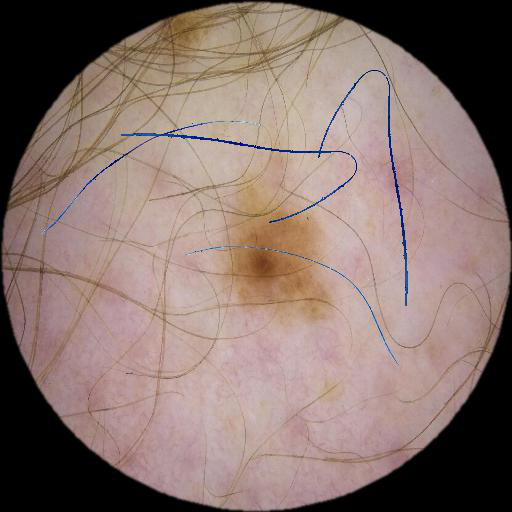

In [13]:
test_hair_images =['ISIC_0078712','ISIC_0080817','ISIC_0082348','ISIC_0109869','ISIC_0155012','ISIC_0159568','ISIC_0164145','ISIC_0194550','ISIC_0194914','ISIC_0202023']
path ="/home/jupyter/kaggle/melanoma_repo/data/01_raw/cropped/"

# Image.open(path + test_hair_images[0]+".jpg")


# data load

In [6]:
from datetime import datetime
EXEC_TIME=datetime.now().strftime("%Y%m%d_%H%M")

In [7]:
from pathlib import Path
from kedro.framework.context import load_context

current_dir = Path.cwd()  # this points to 'notebooks/' folder
proj_path = current_dir.parent  # point back to the root of the project
context = load_context(proj_path)
catalog = context.catalog

In [8]:
train_df=catalog.load("train")
test_df= catalog.load("test")

2020-07-16 02:46:06,680 - kedro.io.data_catalog - INFO - Loading data from `train` (CSVDataSet)...
2020-07-16 02:46:06,918 - kedro.io.data_catalog - INFO - Loading data from `test` (CSVDataSet)...


In [9]:
train_df[(train_df.target == 1)  ]


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
91,ISIC_0149568,IP_0962375,female,55.0,upper extremity,melanoma,malignant,1
235,ISIC_0188432,IP_0135517,female,50.0,upper extremity,melanoma,malignant,1
314,ISIC_0207268,IP_7735373,male,55.0,torso,melanoma,malignant,1
399,ISIC_0232101,IP_8349964,male,65.0,torso,melanoma,malignant,1
459,ISIC_0247330,IP_3232631,female,65.0,lower extremity,melanoma,malignant,1
...,...,...,...,...,...,...,...,...
32969,ISIC_9955163,IP_7507212,male,55.0,upper extremity,melanoma,malignant,1
33000,ISIC_9963177,IP_1165806,male,70.0,torso,melanoma,malignant,1
33014,ISIC_9967383,IP_7887363,male,60.0,upper extremity,melanoma,malignant,1
33050,ISIC_9978107,IP_2860540,male,65.0,lower extremity,melanoma,malignant,1


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# feature engineering

In [11]:
# concat = pd.concat([train_df['anatom_site_general_challenge'], test_df['anatom_site_general_challenge']], ignore_index=True)
import gc


def get_segment_age(age_approx):
    """
    segment は
    0~10
    15~55
    60~85
    90
    に分ける
    """
    # 冗長的。直したい
    feature_list=["age_0_10",
                  "age_15_55",
                  "age_60_85",
                  "age_90_max"]
    _df =pd.DataFrame(0, index=np.arange(len(age_approx)), columns=feature_list)
#     age_approx = df.age_approx
    _df["age_0_10"] = (age_approx < 15 )*1
    _df["age_15_55"] = ( (15<= age_approx ) &  (age_approx <60)) * 1
    _df["age_60_85"] = ( (60 <= age_approx ) &  (age_approx <90)) * 1
    _df["age_90_max"] =(90 <= age_approx) * 1
    return _df
                  
    
    
def build_metafeatures(df):
    dummies = pd.get_dummies(df[['sex','anatom_site_general_challenge']], dummy_na=True, dtype=np.uint8)
    dummies = pd.concat([dummies, get_segment_age(df.age_approx)], axis=1)
#     df.age_approx /= df.age_approx.max()
    
#     meta_features=pd.concat([dummies,normalized_age_approx], axis=1)
    return pd.concat([df,dummies],axis=1), dummies.columns.tolist()

def augmentation_df(df,image_folders:list ):
    _df = df.copy()
    image_name = _df.image_name
#     _df = _df.drop("image_name",axis=1)
    for i, img_folder in enumerate(image_folders):
        if i == 0:
            df.image_name = img_folder +  df.image_name
            print(len(df))
            continue
        
        _df["image_name"] =  img_folder + image_name
        df=pd.concat([df,_df],ignore_index=True)
        print(f"df add {img_folder},{len(df)}")
    del _df,image_name
    gc.collect()
    
    return df
# train_df ,meta_features = build_metafeatures(train_df)
# _train_df = augmentation_df(_train_df,["/home/jupyter/kaggle/melanoma_repo/data/01_raw/cropped","/home/jupyter/kaggle/melanoma_repo/data/01_raw/cropped_aug"])

In [8]:
_train_df,meta_features = build_metafeatures(train_df)
_train_df= augmentation_df(_train_df,[
    "/home/jupyter/kaggle/melanoma_repo/data/01_raw/cropped_min/",
#     "/home/jupyter/kaggle/melanoma_repo/data/01_raw/jpeg/train/",
    
#                            "/home/jupyter/kaggle/melanoma_repo/data/01_raw/cropped_aug/"
                                     ])

2020-07-10 06:59:25,582 - numexpr.utils - INFO - NumExpr defaulting to 2 threads.
33126


## transforms

In [9]:
# transforms 部分

class Contrasten:
    import numpy as np
    def __init__(self,alpha:int=1):
        self.alpha = 1 + alpha
        
    def __call__(self,img):
        img_enhance = ImageEnhance.Contrast(img)
        return np.asarray(img_enhance.enhance(self.alpha))
    def __repr__(self):
        return f"{self.__class__.__name__}(alpha={self.alpha})"

    
    
class Album:
    lib = None
    def __init__(self,lib, *args,**kwargs):
        self.lib = lib
#         self.lib = self.lib(*args,**kwargs)
    def __call__(self,img):
        return self.lib(image= img)
        
    
class _Horizontal(Album):
#     def __init(self, *args)
    lib = A.HorizontalFlip



In [10]:
from  PIL import Image, ImageEnhance


In [11]:
class Swish(nn.Module):  # Swish activation                                      
    def forward(self, x):
        return x * torch.sigmoid(x)

    
    


# Dataset

In [12]:
class MelanomaDataset(Dataset):
    def __init__(self, df: pd.DataFrame, imfolder: str, train: bool = True, transforms = None, meta_features = None, contrast=1.5):
        """
        Class initialization
        Args:
            df (pd.DataFrame): DataFrame with data description
            imfolder (str): folder with images
            train (bool): flag of whether a training dataset is being initialized or testing one
            transforms: image transformation method to be applied
            meta_features (list): list of features with meta information, such as sex and age
            
        """
        self.df = df
        self.imfolder = imfolder
        self.transforms = transforms
        self.train = train
        self.meta_features = meta_features
        self.contrast = contrast
        self.to_tensor = ToTensor()
        
    def __getitem__(self, index):
        im_path = self.df.iloc[index]['image_name'] + '.jpg'
        x=Image.open(im_path)
        
#         x = 
#         x = cv2.imread(im_path)
#         x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
        meta = np.array(self.df.iloc[index][self.meta_features].values, dtype=np.float32)

        if self.transforms:
            x = self.transforms(x)
            
        if self.train:
            y = self.df.iloc[index]['target']
            
#             y=torch.from_numpy(np.asarray(y))
#             print(y,y.size)
#             y =torch.unsqueeze(y,1)
#             print(y,y.shape)
            return (x, meta), y
        else:
            return (x, meta)
    
    def __len__(self):
        return len(self.df)

    
class NetProto(nn.Module):
    def __init__(self, arch, n_meta_features: int):
        super(NetProto, self).__init__()
        self.arch = arch
        if 'ResNet' in str(arch.__class__):
            self.arch.fc = nn.Linear(in_features=512, out_features=500, bias=True)
        if 'EfficientNet' in str(arch.__class__):
            num_ftrs = self.arch._fc.in_features
            self.arch._fc = nn.Linear(in_features=num_ftrs, out_features=500, bias=True)
            
        self.meta = nn.Sequential(nn.Linear(n_meta_features, 500),
                                  nn.BatchNorm1d(500),
                                  Swish(),
#                                   nn.ReLU(),
                                  nn.Dropout(p=0.2),
                                  nn.Linear(500, 250),  # FC layer output will have 250 features
                                  nn.BatchNorm1d(250),
                                  Swish(),
#                                   nn.ReLU(),
                                  nn.Dropout(p=0.2))
        self.ouput = nn.Linear(500 + 250
                               ,
                               1)
        
    def forward(self, inputs):
        """
        No sigmoid in forward because we are going to use BCEWithLogitsLoss
        Which applies sigmoid for us when calculating a loss
        """
        x, meta = inputs
        cnn_features = self.arch(x)
#         features = self.arch(x)
        
        meta_features = self.meta(meta)
        features = torch.cat((cnn_features, meta_features), dim=1)
    
        output = self.ouput(features)
        output=output.float()
#         print(output)
        return output

In [13]:
from ignite.contrib.metrics import ROC_AUC

In [14]:
# to_tensor = transforms.ToTensor()

In [15]:
# import cv2
# img = cv2.imread("/home/jupyter/kaggle/melanoma_repo/data/01_raw/cropped/ISIC_6260086.jpg")
    
# hoge = _Horizontal(p=1)
# hoge(img)


In [16]:
# img=Image.open('/kaggle/input/melanoma-external-malignant-256/train/train/ISIC_6260086.jpg',) 

In [17]:
# img=Image.open("/home/jupyter/kaggle/melanoma_repo/data/01_raw/cropped/ISIC_6260086.jpg")
# img2=Image.open("/home/jupyter/kaggle/melanoma_repo/data/01_raw/external_malignant/train/ISIC_6260086.jpg")

# train_transform = transforms.Compose([
#     Contrasten(alpha=.5),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
#     ])

# hoge = img.copy()
# # print(train_transform)
# hoge=Contrasten(alpha=.5)(hoge)
# hoge=transforms.ToTensor()(hoge)
# # hoge=transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])(hoge)

# hoge=hoge.to("cpu").detach().numpy().copy()
# print(hoge)
# Image.fromarray(hoge)

# hoge.mean()
# plt.imshow(hoge)
# for call in train_transform:
#     hoge=call(hoge)

    
# hoge

In [18]:
from torchvision.transforms import ColorJitter
# color_jitter = ColorJitter(saturation=0.4,contrast=0.4)



In [19]:
from ignite.engine import Engine
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss,ConfusionMatrix
from ignite.contrib.metrics import ROC_AUC

def get_data_loaders(train_batch_size,trian_idx,val_idx, val_batch_size,imfolder="/home/jupyter/kaggle/melanoma_repo/data/01_raw/cropped_aug/"):
    """
    data_loader を取得する
    
    """
    data_transform = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])
    
    
    
    train_transform = transforms.Compose([
    Contrasten(alpha=.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    ])
    test_transform = transforms.Compose([
        Contrasten(alpha=.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    ])
    
    train_dataset = MelanomaDataset(df=train_df.iloc[train_idx].reset_index(drop=True), 
                            imfolder=imfolder, 
                            train=True, 
                            transforms=train_transform,
                            meta_features=meta_features)

    val_dataset = MelanomaDataset(df=train_df.iloc[val_idx].reset_index(drop=True), 
                            imfolder=imfolder, 
                            train=True, 
                            transforms=train_transform,
                            meta_features=meta_features)
    
    train_loader = DataLoader(dataset=train_dataset, 
                   batch_size=train_batch_size, shuffle=True)

    val_loader = DataLoader(dataset=val_dataset, 
                   batch_size=val_batch_size, shuffle=True)

    return train_loader, val_loader

In [20]:
import os
LOG_PATH = "/home/jupyter/kaggle/melanoma_repo/logs"
with open("./hoge","a") as f:
    
    print("lslslsl",file=f)

In [21]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss,ConfusionMatrix
from ignite.contrib.metrics import ROC_AUC
from datetime import datetime
import os
def score_function(engine):
    """
    ignite.handlers.EarlyStopping では指定スコアが上がると改善したと判定する。
    """
    val_loss = engine.state.metrics['roc_auc']
    return val_loss

def write_metrics(metrics, writer, mode: str, epoch: int):
    """print metrics & write metrics to log"""
    roc_auc = metrics['roc_auc']
    loss = metrics['loss']
    print(f"{mode} Results - Epoch: {epoch}  "
          f"Avg roc_auc: {roc_auc:.2f} Avg loss: {loss:.2f}")
    writer.add_scalar(f"{mode}/roc_auc", roc_auc, epoch)
    writer.add_scalar(f"{mode}/loss", loss, epoch)

    
# ちょっと表記変えた方がいいかも
raw_log_path = os.path.join(LOG_PATH,EXEC_TIME)
if not os.path.exists(raw_log_path):
    os.mkdir(raw_log_path)
    
def _train(fold,
    epochs,
          model,
          train_loader,
          valid_loader,
          criterion,
          optimizer, 
          writer,
          device:str,
          log_interval,
          patience=5,
          metrics={}
         ):
    
    
#     def update_model(engine, batch):
#         inputs, targets = batch
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, targets.unsqueeze(1))
#         optimizer.step()
#         return loss.item()
    from ignite.utils import convert_tensor
    def normalize_batch(batch, device = None, non_blocking: bool = False):
        x, y =batch
        return (convert_tensor(x, device=device, non_blocking=non_blocking),
                
        convert_tensor(y, device=device, non_blocking=non_blocking).unsqueeze(1).float(),
        )
    
    
    trainer = create_supervised_trainer(model,
                                        optimizer,
                                       criterion,
                                       device,
                                       prepare_batch=normalize_batch)
    evaluator = create_supervised_evaluator(model,
                                            metrics=metrics,
                                            device=device
    )
    # TODOaccurate をいれる
    @trainer.on(Events.ITERATION_COMPLETED)
    def log_training_loss(engine):
        i = (engine.state.iteration - 1) % len(train_loader) + 1
        if i % log_interval == 0:
            print(f"Epoch[{engine.state.epoch}] Iteration[{i}/{len(train_loader)}] "
                  f"Loss: {engine.state.output:.4f}")

            with open(os.path.join(raw_log_path, "training_loss.log"),"a") as f:
                print(f"Epoch[{engine.state.epoch}] Iteration[{i}/{len(train_loader)}] "
                  f"Loss: {engine.state.output:.4f}",file=f)
            # engine.state.output は criterion(model(input)) を表す？
            writer.add_scalar("training/loss", engine.state.output,
                              engine.state.iteration)
            

#     @trainer.on(Events.EPOCH_COMPLETED)
#     def log_training_results(engine):
#         evaluator.run(valid_loader)
#         metrics = evaluatorevaluator.state.metrics
#         write_metrics(metrics, writer, 'training', engine.state.epoch)

    @trainer.on(Events.EPOCH_COMPLETED)
    def log_validation_results(engine):
        evaluator.run(valid_loader)
        metrics = evaluator.state.metrics
        
        write_metrics(metrics, writer, 'validation', engine.state.epoch)  
        
        
        with open(os.path.join(raw_log_path, "validation_loss.log"),"a") as f:
                print(f"validation Results - Epoch: {engine.state.epoch} "
          f"Avg roc_auc: {metrics['roc_auc']:.4f} Avg loss: {metrics['loss']:.4f}",file=f)
            
    

    
    # # Checkpoint setting
    # ./checkpoints/sample_mymodel_{step_number}
    # n_saved 個までパラメータを保持する
    handler = ModelCheckpoint(dirname=f"/home/jupyter/kaggle/melanoma_repo/data/06_models/checkpoints/fold_{fold}_"+EXEC_TIME, filename_prefix='start',
                               n_saved=3, create_dir=True)
    trainer.add_event_handler(Events.EPOCH_COMPLETED, handler, {'mymodel': model})

    # # Early stopping
    handler = EarlyStopping(patience=patience, score_function=score_function, trainer=trainer)
    # Note: the handler is attached to an *Evaluator* (runs one epoch on validation dataset)
    evaluator.add_event_handler(Events.COMPLETED, handler)

    # kick everything off
    trainer.run(train_loader, max_epochs=epochs)


In [22]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=0, eps=1e-7):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.eps = eps

    def forward(self, inputs, target):
#         y = one_hot(target, input.size(-1))

        logit = torch.sigmoid(inputs)
        logit = logit.clamp(self.eps, 1. - self.eps)

        loss = -1 * target * torch.log(logit) # cross entropy
        loss = loss * (1 - logit) ** self.gamma # focal loss

        return loss.sum()

In [23]:

# class _RandomSizedCrop(Album):
#     lib = A.RandomSizedCrop
# class _HorizontalFlip(Album):
#     lib  =A.HorizontalFlip
# class _VerticalFlip(Album):
#     lib = A.VerticalFlip
# class _GaussianBlur(Album):
#     lib = A.GaussianBlur
# class _Cutout(Album):
#     lib = A.Cutout


#               A.RandomSizedCrop(min_max_height=(int(resolution*0.7), input_res),
#                               height=resolution, width=resolution, p=1.0),
#             A.HorizontalFlip(p=0.5),
#             A.(p=0.5),
#             A.GaussianBlur(p=0.3),
        
#             A.Cutout

In [24]:
class AdvancedHairAugmentation:
    def __init__(self, hairs: int = 4, hairs_folder: str = "/home/jupyter/kaggle/melanoma_repo/data/01_raw/hair_imgs"):
        self.hairs = hairs
        self.hairs_folder = hairs_folder
        self.hair_images = [im for im in os.listdir(self.hairs_folder) if 'png' in im]
    def __call__(self, img):
        n_hairs = random.randint(0, self.hairs)

        if not n_hairs:
            return img

        height, width, _ = img.shape  # target image width and height
        img.flags.writeable = True
#         print(img.flags.writeable)
        for _ in range(n_hairs):
            hair = cv2.imread(os.path.join(self.hairs_folder, random.choice(self.hair_images)))
            hair = cv2.flip(hair, random.choice([-1, 0, 1]))
            hair = cv2.rotate(hair, random.choice([0, 1, 2]))

            h_height, h_width, _ = hair.shape  # hair image width and height
            roi_ho = random.randint(0, img.shape[0] - hair.shape[0])
            roi_wo = random.randint(0, img.shape[1] - hair.shape[1])
            roi = img[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width]

            img2gray = cv2.cvtColor(hair, cv2.COLOR_BGR2GRAY)
            ret, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
            mask_inv = cv2.bitwise_not(mask)
            img_bg = cv2.bitwise_and(roi, roi, mask=mask_inv)
            hair_fg = cv2.bitwise_and(hair, hair, mask=mask)

            dst = cv2.add(img_bg, hair_fg)
            
            img[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width] = dst

        return img

In [25]:
# hoge = AdvancedHairAugmentation(6)
# img

# Main (宣言）

In [26]:
# 訓練メイン処理
from tensorboardX import SummaryWriter
from ignite.handlers import ModelCheckpoint, Checkpoint,EarlyStopping
log_writer = SummaryWriter("/home/jupyter/kaggle/melanoma_repo/logs")

LOG_INTERVAL = 10

# criterion = nn.BCEWithLogitsLoss()
criterion = FocalLoss(2.)

metrics = {
    "confusion_matrix": ConfusionMatrix(1),
    "roc_auc": ROC_AUC(),
    "loss":Loss(criterion)
}

#     model = Net(arch=arch, n_meta_features=128)  # TODO これはかくCVごとに初期化する


epochs = 20  # Number of epochs to run　TODO param か
model_path = 'model.pth'  # Path and filename to save model to
es_espatience = 3  # Early Stopping patience - for how many epochs with no improvements to wait
TTA = 3 # Test Time Augmentation rounds
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
oof = np.zeros((len(train_df), 1))  # Out Of Fold predictions
# preds = torch.zeros((len(test), 1), dtype=torch.float32, device=device) ra # Predictions for test test
resolution = 456  # orignal res for B5
input_res  = 512

transform = transforms.Compose([
            Contrasten(alpha=.6),
#             AdvancedHairAugmentation(6),
#             transforms.ColorJitter(brightness=.4,contrast=0.5,saturation=.4),
    
    
#             Album(A.RandomSizedCrop(min_max_height=(int(resolution*0.7), input_res),
#                               height=resolution, width=resolution, p=1.0),),
#     A.HorizontalFlip(p=0.5),
#             A.VerticalFlip(p=0.5),
# A.GaussianBlur(p=0.3),
# A.Cutout(num_holes=8, max_h_size=resolution//8, max_w_size=resolution//8, fill_value=0, p=0.3),
#     ToTensorV2(),
#             Album(A.HorizontalFlip(p=0.5),),
#             Album(A.VerticalFlip(p=0.5),),
#             Album(A.GaussianBlur(p=0.3),),
#             Album(A.Cutout(num_holes=8, max_h_size=resolution//8, max_w_size=resolution//8, fill_value=0, p=0.3),),


transforms.ToTensor(),
# transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

arch = EfficientNet.from_pretrained('efficientnet-b5') # TODO param化

skf = StratifiedKFold(n_splits=5, random_state=999, shuffle=True)
# skf = GroupKFold(n_splits=5)

Loaded pretrained weights for efficientnet-b5


In [27]:
MODEL_CHECKPOINT_PATH ="/home/jupyter/kaggle/melanoma_repo/data/06_models/checkpoints/start_20200710_0306/start_mymodel_2484.pt"



# Main(実行)

In [28]:
# We stratify by target value, thus, according to sklearn StratifiedKFold documentation
# We can fill `X` with zeroes of corresponding length to use it as a placeholder
# since we only need `y` to stratify the data
# for fold, (train_idx, val_idx) in enumerate(skf.split(X=np.zeros(len(train_df)), y=train_df['target']), 1):
for fold, (train_idx, val_idx) in enumerate(skf.split(X=np.zeros(len(_train_df)), y=_train_df['target'], groups=_train_df['patient_id'].tolist()), 1):
    print('=' * 20, 'Fold', fold, '=' * 20)
    if fold == 1:
        print("this fold is skipped")
        continue
    best_val = None  # Best validation score within this fold
    patience = es_espatience # Current patience counter
    
    model = NetProto(arch=arch, n_meta_features=len(meta_features))  # New model for each fold
    model = model.to(device)
    
    if fold == 1 and MODEL_CHECKPOINT_PATH is not None:
        print(f"reading weight {MODEL_CHECKPOINT_PATH}")
        model.load_state_dict(torch.load(MODEL_CHECKPOINT_PATH))
    model=torch.nn.DataParallel(model)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # 可変できるなら可変で
#     optim = torch.optim.Adam(model.parameters(), lr=0.001)# TODO param化
    scheduler = ReduceLROnPlateau(optimizer=optimizer, mode='max', patience=1, verbose=True, factor=0.2)
    criterion = nn.BCEWithLogitsLoss()#FocalLoss(2.)#
    
    train = MelanomaDataset(df=_train_df.iloc[train_idx].reset_index(drop=True), 
                            imfolder='/home/jupyter/kaggle/melanoma_repo/data/01_raw/cropped_min/', 
                            train=True, 
                            transforms=transform,
                            meta_features=meta_features)
    val = MelanomaDataset(df=_train_df.iloc[val_idx].reset_index(drop=True), 
                            imfolder='/home/jupyter/kaggle/melanoma_repo/data/01_raw/cropped_min/', 
                            train=True, 
                            transforms=transform,
                            meta_features=meta_features)
    
    train_loader = DataLoader(dataset=train, batch_size=64, shuffle=True, num_workers=4,drop_last=True)
    val_loader = DataLoader(dataset=val, batch_size=16, shuffle=False, num_workers=4)
    _train(fold,
        epochs,
          model,
          train_loader,
          val_loader,
          criterion,
          optimizer,
          log_writer,
          device,
          LOG_INTERVAL,
          patience,
          metrics
          
     )
#     test_loader = DataLoader(dataset=test, batch_size=16, shuffle=False, num_workers=2)
    
#     for epoch in range(epochs):
#         start_time = time.time()
#         correct = 0
#         epoch_loss = 0
#         model.train()
        
#         for x, y in train_loader:
#             x[0] = torch.tensor(x[0], device=device, dtype=torch.float32)
#             x[1] = torch.tensor(x[1], device=device, dtype=torch.float32)
#             y = torch.tensor(y, device=device, dtype=torch.float32)
#             optim.zero_grad()
#             z = model(x)
#             loss = criterion(z, y.unsqueeze(1))
#             loss.backward()
#             optim.step()
#             pred = torch.round(torch.sigmoid(z))  # round off sigmoid to obtain predictions
#             correct += (pred.cpu() == y.cpu().unsqueeze(1)).sum().item()  # tracking number of correctly predicted samples
#             epoch_loss += loss.item()
#         train_acc = correct / len(train_idx)

#         model.eval()  # switch model to the evaluation mode
#         val_preds = torch.zeros((len(val_idx), 1), dtype=torch.float32, device=device)
#         with torch.no_grad():  # Do not calculate gradient since we are only predicting
#             # Predicting on validation set
#             for j, (x_val, y_val) in enumerate(val_loader):
#                 x_val[0] = torch.tensor(x_val[0], device=device, dtype=torch.float32)
#                 x_val[1] = torch.tensor(x_val[1], device=device, dtype=torch.float32)
#                 y_val = torch.tensor(y_val, device=device, dtype=torch.float32)
#                 z_val = model(x_val)
#                 val_pred = torch.sigmoid(z_val)
#                 val_preds[j*x_val[0].shape[0]:j*x_val[0].shape[0] + x_val[0].shape[0]] = val_pred
#             val_acc = accuracy_score(train_df.iloc[val_idx]['target'].values, torch.round(val_preds.cpu()))
#             val_roc = roc_auc_score(train_df.iloc[val_idx]['target'].values, val_preds.cpu())
            
#             print('Epoch {:03}: | Loss: {:.3f} | Train acc: {:.3f} | Val acc: {:.3f} | Val roc_auc: {:.3f} | Training time: {}'.format(
#             epoch + 1, 
#             epoch_loss, 
#             train_acc, 
#             val_acc, 
#             val_roc, 
#             str(datetime.timedelta(seconds=time.time() - start_time))[:7]))
            
#             scheduler.step(val_roc)
#             # During the first iteration (first epoch) best validation is set to None
#             if not best_val:
#                 best_val = val_roc  # So any validation roc_auc we have is the best one for now
#                 torch.save(model, model_path)  # Saving the model
#                 continue
                
#             if val_roc >= best_val:
#                 best_val = val_roc
#                 patience = es_patience  # Resetting patience since we have new best validation accuracy
#                 torch.save(model, model_path)  # Saving current best model
#             else:
#                 patience -= 1
#                 if patience == 0:
#                     print('Early stopping. Best Val roc_auc: {:.3f}'.format(best_val))
#                     break
                
#     model = torch.load(model_path)  # Loading best model of this fold
#     model.eval()  # switch model to the evaluation mode
#     val_preds = torch.zeros((len(val_idx), 1), dtype=torch.float32, device=device)
    
#     with torch.no_grad():
#         # Predicting on validation set once again to obtain data for OOF
#         for j, (x_val, y_val) in enumerate(val_loader):
#             x_val[0] = torch.tensor(x_val[0], device=device, dtype=torch.float32)
#             x_val[1] = torch.tensor(x_val[1], device=device, dtype=torch.float32)
#             y_val = torch.tensor(y_val, device=device, dtype=torch.float32)
#             z_val = model(x_val)
#             val_pred = torch.sigmoid(z_val)
#             val_preds[j*x_val[0].shape[0]:j*x_val[0].shape[0] + x_val[0].shape[0]] = val_pred
#         oof[val_idx] = val_preds.cpu().numpy()
        
#         # Predicting on test set
#         for _ in range(TTA):
#             for i, x_test in enumerate(test_loader):
#                 x_test[0] = torch.tensor(x_test[0], device=device, dtype=torch.float32)
#                 x_test[1] = torch.tensor(x_test[1], device=device, dtype=torch.float32)
#                 z_test = model(x_test)
#                 z_test = torch.sigmoid(z_test)
#                 preds[i*x_test[0].shape[0]:i*x_test[0].shape[0] + x_test[0].shape[0]] += z_test
#         preds /= TTA
        
    del train, val, train_loader, val_loader ,model#x_val, y_val
    gc.collect()
    
# preds /= skf.n_splits

==================== Fold 1 ====================
this fold is skipped
==================== Fold 2 ====================
2020-07-10 06:59:28,463 - ignite.engine.engine.Engine - INFO - Engine run starting with max_epochs=20.


/opt/anaconda3/lib/python3.7/site-packages/efficientnet_pytorch/utils.py:45: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  i = ctx.saved_variables[0]


Epoch[1] Iteration[10/414] Loss: 0.1142
Epoch[1] Iteration[20/414] Loss: 0.1889
Epoch[1] Iteration[30/414] Loss: 0.1123
Epoch[1] Iteration[40/414] Loss: 0.1406
Epoch[1] Iteration[50/414] Loss: 0.0399
Epoch[1] Iteration[60/414] Loss: 0.0330
Epoch[1] Iteration[70/414] Loss: 0.0125
Epoch[1] Iteration[80/414] Loss: 0.0959
Epoch[1] Iteration[90/414] Loss: 0.0716
Epoch[1] Iteration[100/414] Loss: 0.0604
Epoch[1] Iteration[110/414] Loss: 0.0143
Epoch[1] Iteration[120/414] Loss: 0.0199
Epoch[1] Iteration[130/414] Loss: 0.3177
Epoch[1] Iteration[140/414] Loss: 0.1500
Epoch[1] Iteration[150/414] Loss: 0.0754
Epoch[1] Iteration[160/414] Loss: 0.0177
Epoch[1] Iteration[170/414] Loss: 0.1349
Epoch[1] Iteration[180/414] Loss: 0.0423
Epoch[1] Iteration[190/414] Loss: 0.0831
Epoch[1] Iteration[200/414] Loss: 0.0356
Epoch[1] Iteration[210/414] Loss: 0.1443
Epoch[1] Iteration[220/414] Loss: 0.1798
Epoch[1] Iteration[230/414] Loss: 0.0093
Epoch[1] Iteration[240/414] Loss: 0.0631
Epoch[1] Iteration[250/41

/opt/anaconda3/lib/python3.7/site-packages/efficientnet_pytorch/utils.py:45: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  i = ctx.saved_variables[0]


Epoch[2] Iteration[10/414] Loss: 0.0626
Epoch[2] Iteration[20/414] Loss: 0.0914
Epoch[2] Iteration[30/414] Loss: 0.0186
Epoch[2] Iteration[40/414] Loss: 0.1176
Epoch[2] Iteration[50/414] Loss: 0.0656
Epoch[2] Iteration[60/414] Loss: 0.1890
Epoch[2] Iteration[70/414] Loss: 0.0742
Epoch[2] Iteration[80/414] Loss: 0.0134
Epoch[2] Iteration[90/414] Loss: 0.0859
Epoch[2] Iteration[100/414] Loss: 0.1463
Epoch[2] Iteration[110/414] Loss: 0.1077
Epoch[2] Iteration[120/414] Loss: 0.1212
Epoch[2] Iteration[130/414] Loss: 0.1481
Epoch[2] Iteration[140/414] Loss: 0.0133
Epoch[2] Iteration[150/414] Loss: 0.0706
Epoch[2] Iteration[160/414] Loss: 0.0172
Epoch[2] Iteration[170/414] Loss: 0.0179
Epoch[2] Iteration[180/414] Loss: 0.0036
Epoch[2] Iteration[190/414] Loss: 0.0517
Epoch[2] Iteration[200/414] Loss: 0.1848
Epoch[2] Iteration[210/414] Loss: 0.1253
Epoch[2] Iteration[220/414] Loss: 0.0582
Epoch[2] Iteration[230/414] Loss: 0.1265
Epoch[2] Iteration[240/414] Loss: 0.1070
Epoch[2] Iteration[250/41

/opt/anaconda3/lib/python3.7/site-packages/efficientnet_pytorch/utils.py:45: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  i = ctx.saved_variables[0]


Epoch[3] Iteration[10/414] Loss: 0.1978
Epoch[3] Iteration[20/414] Loss: 0.0061
Epoch[3] Iteration[30/414] Loss: 0.0983
Epoch[3] Iteration[40/414] Loss: 0.0814
Epoch[3] Iteration[50/414] Loss: 0.0667
Epoch[3] Iteration[60/414] Loss: 0.0553
Epoch[3] Iteration[70/414] Loss: 0.1054
Epoch[3] Iteration[80/414] Loss: 0.1177
Epoch[3] Iteration[90/414] Loss: 0.0211
Epoch[3] Iteration[100/414] Loss: 0.0990
Epoch[3] Iteration[110/414] Loss: 0.0337
Epoch[3] Iteration[120/414] Loss: 0.0500
Epoch[3] Iteration[130/414] Loss: 0.1126
Epoch[3] Iteration[140/414] Loss: 0.1547
Epoch[3] Iteration[150/414] Loss: 0.0154
Epoch[3] Iteration[160/414] Loss: 0.1190
Epoch[3] Iteration[170/414] Loss: 0.0496
Epoch[3] Iteration[180/414] Loss: 0.1110
Epoch[3] Iteration[190/414] Loss: 0.0424
Epoch[3] Iteration[200/414] Loss: 0.0803
Epoch[3] Iteration[210/414] Loss: 0.0833
Epoch[3] Iteration[220/414] Loss: 0.0985
Epoch[3] Iteration[230/414] Loss: 0.1067
Epoch[3] Iteration[240/414] Loss: 0.0496
Epoch[3] Iteration[250/41

/opt/anaconda3/lib/python3.7/site-packages/efficientnet_pytorch/utils.py:45: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  i = ctx.saved_variables[0]


Epoch[4] Iteration[10/414] Loss: 0.1469
Epoch[4] Iteration[20/414] Loss: 0.1164
Epoch[4] Iteration[30/414] Loss: 0.0125
Epoch[4] Iteration[40/414] Loss: 0.1798
Epoch[4] Iteration[50/414] Loss: 0.0304
Epoch[4] Iteration[60/414] Loss: 0.0762
Epoch[4] Iteration[70/414] Loss: 0.1164
Epoch[4] Iteration[80/414] Loss: 0.0291
Epoch[4] Iteration[90/414] Loss: 0.0251
Epoch[4] Iteration[100/414] Loss: 0.0932
Epoch[4] Iteration[110/414] Loss: 0.0461
Epoch[4] Iteration[120/414] Loss: 0.0716
Epoch[4] Iteration[130/414] Loss: 0.0409
Epoch[4] Iteration[140/414] Loss: 0.1056
Epoch[4] Iteration[150/414] Loss: 0.1958
Epoch[4] Iteration[160/414] Loss: 0.1035
Epoch[4] Iteration[170/414] Loss: 0.1251
Epoch[4] Iteration[180/414] Loss: 0.0592
Epoch[4] Iteration[190/414] Loss: 0.1275
Epoch[4] Iteration[200/414] Loss: 0.0808
Epoch[4] Iteration[210/414] Loss: 0.0194
Epoch[4] Iteration[220/414] Loss: 0.1127
Epoch[4] Iteration[230/414] Loss: 0.1016
Epoch[4] Iteration[240/414] Loss: 0.0985
Epoch[4] Iteration[250/41

/opt/anaconda3/lib/python3.7/site-packages/efficientnet_pytorch/utils.py:45: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  i = ctx.saved_variables[0]


Epoch[5] Iteration[10/414] Loss: 0.1228
Epoch[5] Iteration[20/414] Loss: 0.0099
Epoch[5] Iteration[30/414] Loss: 0.1166
Epoch[5] Iteration[40/414] Loss: 0.0459
Epoch[5] Iteration[50/414] Loss: 0.0755
Epoch[5] Iteration[60/414] Loss: 0.0340
Epoch[5] Iteration[70/414] Loss: 0.0681
Epoch[5] Iteration[80/414] Loss: 0.0996
Epoch[5] Iteration[90/414] Loss: 0.0956
Epoch[5] Iteration[100/414] Loss: 0.1141
Epoch[5] Iteration[110/414] Loss: 0.0629
Epoch[5] Iteration[120/414] Loss: 0.0641
Epoch[5] Iteration[130/414] Loss: 0.0032
Epoch[5] Iteration[140/414] Loss: 0.1344
Epoch[5] Iteration[150/414] Loss: 0.0369
Epoch[5] Iteration[160/414] Loss: 0.1251
Epoch[5] Iteration[170/414] Loss: 0.0476
Epoch[5] Iteration[180/414] Loss: 0.0751
Epoch[5] Iteration[190/414] Loss: 0.1536
Epoch[5] Iteration[200/414] Loss: 0.0594
Epoch[5] Iteration[210/414] Loss: 0.0818
Epoch[5] Iteration[220/414] Loss: 0.0898
Epoch[5] Iteration[230/414] Loss: 0.0516
Epoch[5] Iteration[240/414] Loss: 0.0917
Epoch[5] Iteration[250/41

/opt/anaconda3/lib/python3.7/site-packages/efficientnet_pytorch/utils.py:45: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  i = ctx.saved_variables[0]


Epoch[1] Iteration[10/414] Loss: 0.1208
Epoch[1] Iteration[20/414] Loss: 0.2324
Epoch[1] Iteration[30/414] Loss: 0.0872
Epoch[1] Iteration[40/414] Loss: 0.0119
Epoch[1] Iteration[50/414] Loss: 0.0593
Epoch[1] Iteration[60/414] Loss: 0.1160
Epoch[1] Iteration[70/414] Loss: 0.2232
Epoch[1] Iteration[80/414] Loss: 0.0966
Epoch[1] Iteration[90/414] Loss: 0.1284
Epoch[1] Iteration[100/414] Loss: 0.0414
Epoch[1] Iteration[110/414] Loss: 0.0635
Epoch[1] Iteration[120/414] Loss: 0.0791
Epoch[1] Iteration[130/414] Loss: 0.1386
Epoch[1] Iteration[140/414] Loss: 0.0817
Epoch[1] Iteration[150/414] Loss: 0.0077
Epoch[1] Iteration[160/414] Loss: 0.0900
Epoch[1] Iteration[170/414] Loss: 0.1118
Epoch[1] Iteration[180/414] Loss: 0.0099
Epoch[1] Iteration[190/414] Loss: 0.0376
Epoch[1] Iteration[200/414] Loss: 0.1340
Epoch[1] Iteration[210/414] Loss: 0.0344
Epoch[1] Iteration[220/414] Loss: 0.0264
Epoch[1] Iteration[230/414] Loss: 0.0787
Epoch[1] Iteration[240/414] Loss: 0.0922
Epoch[1] Iteration[250/41

/opt/anaconda3/lib/python3.7/site-packages/efficientnet_pytorch/utils.py:45: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  i = ctx.saved_variables[0]


Epoch[2] Iteration[10/414] Loss: 0.0232
Epoch[2] Iteration[20/414] Loss: 0.0426
Epoch[2] Iteration[30/414] Loss: 0.0785
Epoch[2] Iteration[40/414] Loss: 0.0929
Epoch[2] Iteration[50/414] Loss: 0.0588
Epoch[2] Iteration[60/414] Loss: 0.0164
Epoch[2] Iteration[70/414] Loss: 0.0657
Epoch[2] Iteration[80/414] Loss: 0.0189
Epoch[2] Iteration[90/414] Loss: 0.1222
Epoch[2] Iteration[100/414] Loss: 0.0232
Epoch[2] Iteration[110/414] Loss: 0.1516
Epoch[2] Iteration[120/414] Loss: 0.0458
Epoch[2] Iteration[130/414] Loss: 0.0349
Epoch[2] Iteration[140/414] Loss: 0.0180
Epoch[2] Iteration[150/414] Loss: 0.0972
Epoch[2] Iteration[160/414] Loss: 0.0236
Epoch[2] Iteration[170/414] Loss: 0.0545
Epoch[2] Iteration[180/414] Loss: 0.1522
Epoch[2] Iteration[190/414] Loss: 0.0143
Epoch[2] Iteration[200/414] Loss: 0.0513
Epoch[2] Iteration[210/414] Loss: 0.0265
Epoch[2] Iteration[220/414] Loss: 0.0457
Epoch[2] Iteration[230/414] Loss: 0.0143
Epoch[2] Iteration[240/414] Loss: 0.0644
Epoch[2] Iteration[250/41

/opt/anaconda3/lib/python3.7/site-packages/efficientnet_pytorch/utils.py:45: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  i = ctx.saved_variables[0]


Epoch[3] Iteration[10/414] Loss: 0.0157
Epoch[3] Iteration[20/414] Loss: 0.0043
Epoch[3] Iteration[30/414] Loss: 0.0236
Epoch[3] Iteration[40/414] Loss: 0.0050
Epoch[3] Iteration[50/414] Loss: 0.0014
Epoch[3] Iteration[60/414] Loss: 0.0286
Epoch[3] Iteration[70/414] Loss: 0.0203
Epoch[3] Iteration[80/414] Loss: 0.0044
Epoch[3] Iteration[90/414] Loss: 0.0122
Epoch[3] Iteration[100/414] Loss: 0.1098
Epoch[3] Iteration[110/414] Loss: 0.0298
Epoch[3] Iteration[120/414] Loss: 0.0138
Epoch[3] Iteration[130/414] Loss: 0.0063
Epoch[3] Iteration[140/414] Loss: 0.0032
Epoch[3] Iteration[150/414] Loss: 0.0110
Epoch[3] Iteration[160/414] Loss: 0.0010
Epoch[3] Iteration[170/414] Loss: 0.0816
Epoch[3] Iteration[180/414] Loss: 0.0416
Epoch[3] Iteration[190/414] Loss: 0.0276
Epoch[3] Iteration[200/414] Loss: 0.0070
Epoch[3] Iteration[210/414] Loss: 0.0445
Epoch[3] Iteration[220/414] Loss: 0.0230
Epoch[3] Iteration[230/414] Loss: 0.0075
Epoch[3] Iteration[240/414] Loss: 0.0110
Epoch[3] Iteration[250/41

/opt/anaconda3/lib/python3.7/site-packages/efficientnet_pytorch/utils.py:45: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  i = ctx.saved_variables[0]


Epoch[4] Iteration[10/414] Loss: 0.0304
Epoch[4] Iteration[20/414] Loss: 0.0023
Epoch[4] Iteration[30/414] Loss: 0.0764
Epoch[4] Iteration[40/414] Loss: 0.0235
Epoch[4] Iteration[50/414] Loss: 0.0024
Epoch[4] Iteration[60/414] Loss: 0.0015
Epoch[4] Iteration[70/414] Loss: 0.0026
Epoch[4] Iteration[80/414] Loss: 0.0006
Epoch[4] Iteration[90/414] Loss: 0.0595
Epoch[4] Iteration[100/414] Loss: 0.0038
Epoch[4] Iteration[110/414] Loss: 0.0014
Epoch[4] Iteration[120/414] Loss: 0.0016
Epoch[4] Iteration[130/414] Loss: 0.0011
Epoch[4] Iteration[140/414] Loss: 0.1346
Epoch[4] Iteration[150/414] Loss: 0.0309
Epoch[4] Iteration[160/414] Loss: 0.0050
Epoch[4] Iteration[170/414] Loss: 0.0002
Epoch[4] Iteration[180/414] Loss: 0.0095
Epoch[4] Iteration[190/414] Loss: 0.0764
Epoch[4] Iteration[200/414] Loss: 0.0044
Epoch[4] Iteration[210/414] Loss: 0.0034
Epoch[4] Iteration[220/414] Loss: 0.0086
Epoch[4] Iteration[230/414] Loss: 0.0026
Epoch[4] Iteration[240/414] Loss: 0.0018
Epoch[4] Iteration[250/41

/opt/anaconda3/lib/python3.7/site-packages/efficientnet_pytorch/utils.py:45: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  i = ctx.saved_variables[0]


Epoch[5] Iteration[10/414] Loss: 0.0038
Epoch[5] Iteration[20/414] Loss: 0.0017
Epoch[5] Iteration[30/414] Loss: 0.0004
Epoch[5] Iteration[40/414] Loss: 0.0452
Epoch[5] Iteration[50/414] Loss: 0.0010
Epoch[5] Iteration[60/414] Loss: 0.0184
Epoch[5] Iteration[70/414] Loss: 0.0403
Epoch[5] Iteration[80/414] Loss: 0.0025
Epoch[5] Iteration[90/414] Loss: 0.0005
Epoch[5] Iteration[100/414] Loss: 0.0008
Epoch[5] Iteration[110/414] Loss: 0.0007
Epoch[5] Iteration[120/414] Loss: 0.0013
Epoch[5] Iteration[130/414] Loss: 0.0231
Epoch[5] Iteration[140/414] Loss: 0.0959
Epoch[5] Iteration[150/414] Loss: 0.0326
Epoch[5] Iteration[160/414] Loss: 0.0278
Epoch[5] Iteration[170/414] Loss: 0.0118
Epoch[5] Iteration[180/414] Loss: 0.0131
Epoch[5] Iteration[190/414] Loss: 0.0104
Epoch[5] Iteration[200/414] Loss: 0.0014
Epoch[5] Iteration[210/414] Loss: 0.0005
Epoch[5] Iteration[220/414] Loss: 0.0011
Epoch[5] Iteration[230/414] Loss: 0.0002
Epoch[5] Iteration[240/414] Loss: 0.0131
Epoch[5] Iteration[250/41

/opt/anaconda3/lib/python3.7/site-packages/efficientnet_pytorch/utils.py:45: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  i = ctx.saved_variables[0]


Epoch[6] Iteration[10/414] Loss: 0.0036
Epoch[6] Iteration[20/414] Loss: 0.0251
Epoch[6] Iteration[30/414] Loss: 0.0392
Epoch[6] Iteration[40/414] Loss: 0.0019
Epoch[6] Iteration[50/414] Loss: 0.0008
Epoch[6] Iteration[60/414] Loss: 0.0132
Epoch[6] Iteration[70/414] Loss: 0.0030
Epoch[6] Iteration[80/414] Loss: 0.0001
Epoch[6] Iteration[90/414] Loss: 0.0003
Epoch[6] Iteration[100/414] Loss: 0.0670
Epoch[6] Iteration[110/414] Loss: 0.0103
Epoch[6] Iteration[120/414] Loss: 0.0008
Epoch[6] Iteration[130/414] Loss: 0.0002
Epoch[6] Iteration[140/414] Loss: 0.0008
Epoch[6] Iteration[150/414] Loss: 0.0005
Epoch[6] Iteration[160/414] Loss: 0.0290
Epoch[6] Iteration[170/414] Loss: 0.0015
Epoch[6] Iteration[180/414] Loss: 0.0064
Epoch[6] Iteration[190/414] Loss: 0.0090
Epoch[6] Iteration[200/414] Loss: 0.0003
Epoch[6] Iteration[210/414] Loss: 0.0353
Epoch[6] Iteration[220/414] Loss: 0.0043
Epoch[6] Iteration[230/414] Loss: 0.0004
Epoch[6] Iteration[240/414] Loss: 0.0694
Epoch[6] Iteration[250/41

/opt/anaconda3/lib/python3.7/site-packages/efficientnet_pytorch/utils.py:45: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  i = ctx.saved_variables[0]


Epoch[1] Iteration[10/414] Loss: 0.0000
Epoch[1] Iteration[20/414] Loss: 0.2423
Epoch[1] Iteration[30/414] Loss: 0.0070
Epoch[1] Iteration[40/414] Loss: 0.0817
Epoch[1] Iteration[50/414] Loss: 0.0371
Epoch[1] Iteration[60/414] Loss: 0.0075
Epoch[1] Iteration[70/414] Loss: 0.0033
Epoch[1] Iteration[80/414] Loss: 0.0197
Epoch[1] Iteration[90/414] Loss: 0.0879
Epoch[1] Iteration[100/414] Loss: 0.0163
Epoch[1] Iteration[110/414] Loss: 0.0064
Epoch[1] Iteration[120/414] Loss: 0.0373
Epoch[1] Iteration[130/414] Loss: 0.0080
Epoch[1] Iteration[140/414] Loss: 0.0024
Epoch[1] Iteration[150/414] Loss: 0.0475
Epoch[1] Iteration[160/414] Loss: 0.0059
Epoch[1] Iteration[170/414] Loss: 0.1135
Epoch[1] Iteration[180/414] Loss: 0.0023
Epoch[1] Iteration[190/414] Loss: 0.0016
Epoch[1] Iteration[200/414] Loss: 0.0307
Epoch[1] Iteration[210/414] Loss: 0.0388
Epoch[1] Iteration[220/414] Loss: 0.0131
Epoch[1] Iteration[230/414] Loss: 0.0010
Epoch[1] Iteration[240/414] Loss: 0.0010
Epoch[1] Iteration[250/41

/opt/anaconda3/lib/python3.7/site-packages/efficientnet_pytorch/utils.py:45: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  i = ctx.saved_variables[0]


Epoch[2] Iteration[10/414] Loss: 0.0133
Epoch[2] Iteration[20/414] Loss: 0.0190
Epoch[2] Iteration[30/414] Loss: 0.0006
Epoch[2] Iteration[40/414] Loss: 0.0384
Epoch[2] Iteration[50/414] Loss: 0.0008
Epoch[2] Iteration[60/414] Loss: 0.0587
Epoch[2] Iteration[70/414] Loss: 0.0009
Epoch[2] Iteration[80/414] Loss: 0.0166
Epoch[2] Iteration[90/414] Loss: 0.0040
Epoch[2] Iteration[100/414] Loss: 0.0545
Epoch[2] Iteration[110/414] Loss: 0.0255
Epoch[2] Iteration[120/414] Loss: 0.0009
Epoch[2] Iteration[130/414] Loss: 0.0029
Epoch[2] Iteration[140/414] Loss: 0.0014
Epoch[2] Iteration[150/414] Loss: 0.0079
Epoch[2] Iteration[160/414] Loss: 0.1115
Epoch[2] Iteration[170/414] Loss: 0.0271
Epoch[2] Iteration[180/414] Loss: 0.0074
Epoch[2] Iteration[190/414] Loss: 0.0005
Epoch[2] Iteration[200/414] Loss: 0.0271
Epoch[2] Iteration[210/414] Loss: 0.0197
Epoch[2] Iteration[220/414] Loss: 0.0033
Epoch[2] Iteration[230/414] Loss: 0.0011
Epoch[2] Iteration[240/414] Loss: 0.0006
Epoch[2] Iteration[250/41

/opt/anaconda3/lib/python3.7/site-packages/efficientnet_pytorch/utils.py:45: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  i = ctx.saved_variables[0]


Epoch[3] Iteration[10/414] Loss: 0.0005
Epoch[3] Iteration[20/414] Loss: 0.0000
Epoch[3] Iteration[30/414] Loss: 0.0007
Epoch[3] Iteration[40/414] Loss: 0.0030
Epoch[3] Iteration[50/414] Loss: 0.0017
Epoch[3] Iteration[60/414] Loss: 0.0005
Epoch[3] Iteration[70/414] Loss: 0.0006
Epoch[3] Iteration[80/414] Loss: 0.0861
Epoch[3] Iteration[90/414] Loss: 0.0083
Epoch[3] Iteration[100/414] Loss: 0.0008
Epoch[3] Iteration[110/414] Loss: 0.0166
Epoch[3] Iteration[120/414] Loss: 0.0008
Epoch[3] Iteration[130/414] Loss: 0.0044
Epoch[3] Iteration[140/414] Loss: 0.0032
Epoch[3] Iteration[150/414] Loss: 0.0016
Epoch[3] Iteration[160/414] Loss: 0.0007
Epoch[3] Iteration[170/414] Loss: 0.0110
Epoch[3] Iteration[180/414] Loss: 0.0043
Epoch[3] Iteration[190/414] Loss: 0.0064
Epoch[3] Iteration[200/414] Loss: 0.0007
Epoch[3] Iteration[210/414] Loss: 0.0001
Epoch[3] Iteration[220/414] Loss: 0.0030
Epoch[3] Iteration[230/414] Loss: 0.0005
Epoch[3] Iteration[240/414] Loss: 0.0001
Epoch[3] Iteration[250/41

/opt/anaconda3/lib/python3.7/site-packages/efficientnet_pytorch/utils.py:45: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  i = ctx.saved_variables[0]


Epoch[4] Iteration[10/414] Loss: 0.0001
Epoch[4] Iteration[20/414] Loss: 0.0002
Epoch[4] Iteration[30/414] Loss: 0.0002
Epoch[4] Iteration[40/414] Loss: 0.0008
Epoch[4] Iteration[50/414] Loss: 0.0002
Epoch[4] Iteration[60/414] Loss: 0.0001
Epoch[4] Iteration[70/414] Loss: 0.0057
Epoch[4] Iteration[80/414] Loss: 0.0297
Epoch[4] Iteration[90/414] Loss: 0.0000
Epoch[4] Iteration[100/414] Loss: 0.0000
Epoch[4] Iteration[110/414] Loss: 0.0002
Epoch[4] Iteration[120/414] Loss: 0.0360
Epoch[4] Iteration[130/414] Loss: 0.0014
Epoch[4] Iteration[140/414] Loss: 0.0011
Epoch[4] Iteration[150/414] Loss: 0.0052
Epoch[4] Iteration[160/414] Loss: 0.0202
Epoch[4] Iteration[170/414] Loss: 0.0857
Epoch[4] Iteration[180/414] Loss: 0.0041
Epoch[4] Iteration[190/414] Loss: 0.0175
Epoch[4] Iteration[200/414] Loss: 0.0036
Epoch[4] Iteration[210/414] Loss: 0.0004
Epoch[4] Iteration[220/414] Loss: 0.0030
Epoch[4] Iteration[230/414] Loss: 0.0005
Epoch[4] Iteration[240/414] Loss: 0.0008
Epoch[4] Iteration[250/41

/opt/anaconda3/lib/python3.7/site-packages/efficientnet_pytorch/utils.py:45: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  i = ctx.saved_variables[0]


Epoch[1] Iteration[10/414] Loss: 0.0004
Epoch[1] Iteration[20/414] Loss: 0.0041
Epoch[1] Iteration[30/414] Loss: 0.0237
Epoch[1] Iteration[40/414] Loss: 0.0005
Epoch[1] Iteration[50/414] Loss: 0.0145
Epoch[1] Iteration[60/414] Loss: 0.0029
Epoch[1] Iteration[70/414] Loss: 0.1033
Epoch[1] Iteration[80/414] Loss: 0.0148
Epoch[1] Iteration[90/414] Loss: 0.0008
Epoch[1] Iteration[100/414] Loss: 0.0065
Epoch[1] Iteration[110/414] Loss: 0.0014
Epoch[1] Iteration[120/414] Loss: 0.0007
Epoch[1] Iteration[130/414] Loss: 0.0010
Epoch[1] Iteration[140/414] Loss: 0.0028
Epoch[1] Iteration[150/414] Loss: 0.0907
Epoch[1] Iteration[160/414] Loss: 0.0007
Epoch[1] Iteration[170/414] Loss: 0.0032
Epoch[1] Iteration[180/414] Loss: 0.0175
Epoch[1] Iteration[190/414] Loss: 0.0012
Epoch[1] Iteration[200/414] Loss: 0.0678
Epoch[1] Iteration[210/414] Loss: 0.0019
Epoch[1] Iteration[220/414] Loss: 0.0039
Epoch[1] Iteration[230/414] Loss: 0.0013
Epoch[1] Iteration[240/414] Loss: 0.0324
Epoch[1] Iteration[250/41

/opt/anaconda3/lib/python3.7/site-packages/efficientnet_pytorch/utils.py:45: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  i = ctx.saved_variables[0]


Epoch[2] Iteration[10/414] Loss: 0.0118
Epoch[2] Iteration[20/414] Loss: 0.0068
Epoch[2] Iteration[30/414] Loss: 0.0003
Epoch[2] Iteration[40/414] Loss: 0.0008
Epoch[2] Iteration[50/414] Loss: 0.0000
Epoch[2] Iteration[60/414] Loss: 0.0000
Epoch[2] Iteration[70/414] Loss: 0.0001
Epoch[2] Iteration[80/414] Loss: 0.0028
Epoch[2] Iteration[90/414] Loss: 0.0001
Epoch[2] Iteration[100/414] Loss: 0.0001
Epoch[2] Iteration[110/414] Loss: 0.0007
Epoch[2] Iteration[120/414] Loss: 0.0068
Epoch[2] Iteration[130/414] Loss: 0.0001
Epoch[2] Iteration[140/414] Loss: 0.0002
Epoch[2] Iteration[150/414] Loss: 0.0019
Epoch[2] Iteration[160/414] Loss: 0.0002
Epoch[2] Iteration[170/414] Loss: 0.0002
Epoch[2] Iteration[180/414] Loss: 0.0010
Epoch[2] Iteration[190/414] Loss: 0.0004
Epoch[2] Iteration[200/414] Loss: 0.0057
Epoch[2] Iteration[210/414] Loss: 0.0013
Epoch[2] Iteration[220/414] Loss: 0.0049
Epoch[2] Iteration[230/414] Loss: 0.0023
Epoch[2] Iteration[240/414] Loss: 0.0009
Epoch[2] Iteration[250/41

/opt/anaconda3/lib/python3.7/site-packages/efficientnet_pytorch/utils.py:45: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  i = ctx.saved_variables[0]


Epoch[3] Iteration[10/414] Loss: 0.0040
Epoch[3] Iteration[20/414] Loss: 0.0002
Epoch[3] Iteration[30/414] Loss: 0.0154
Epoch[3] Iteration[40/414] Loss: 0.0000
Epoch[3] Iteration[50/414] Loss: 0.0005
Epoch[3] Iteration[60/414] Loss: 0.0051
Epoch[3] Iteration[70/414] Loss: 0.0001
Epoch[3] Iteration[80/414] Loss: 0.0002
Epoch[3] Iteration[90/414] Loss: 0.0013
Epoch[3] Iteration[100/414] Loss: 0.0001
Epoch[3] Iteration[110/414] Loss: 0.0003
Epoch[3] Iteration[120/414] Loss: 0.0001
Epoch[3] Iteration[130/414] Loss: 0.0017
Epoch[3] Iteration[140/414] Loss: 0.0020
Epoch[3] Iteration[150/414] Loss: 0.0005
Epoch[3] Iteration[160/414] Loss: 0.0066
Epoch[3] Iteration[170/414] Loss: 0.0002
Epoch[3] Iteration[180/414] Loss: 0.0511
Epoch[3] Iteration[190/414] Loss: 0.0002
Epoch[3] Iteration[200/414] Loss: 0.0000
Epoch[3] Iteration[210/414] Loss: 0.0014
Epoch[3] Iteration[220/414] Loss: 0.0098
Epoch[3] Iteration[230/414] Loss: 0.0053
Epoch[3] Iteration[240/414] Loss: 0.0049
Epoch[3] Iteration[250/41

/opt/anaconda3/lib/python3.7/site-packages/efficientnet_pytorch/utils.py:45: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  i = ctx.saved_variables[0]


Epoch[4] Iteration[10/414] Loss: 0.0055
Epoch[4] Iteration[20/414] Loss: 0.0014
Epoch[4] Iteration[30/414] Loss: 0.0004
Epoch[4] Iteration[40/414] Loss: 0.0000
Epoch[4] Iteration[50/414] Loss: 0.0031
Epoch[4] Iteration[60/414] Loss: 0.0032
Epoch[4] Iteration[70/414] Loss: 0.0023
Epoch[4] Iteration[80/414] Loss: 0.0009
Epoch[4] Iteration[90/414] Loss: 0.0001
Epoch[4] Iteration[100/414] Loss: 0.0006
Epoch[4] Iteration[110/414] Loss: 0.0002
Epoch[4] Iteration[120/414] Loss: 0.0214
Epoch[4] Iteration[130/414] Loss: 0.0038
Epoch[4] Iteration[140/414] Loss: 0.0002
Epoch[4] Iteration[150/414] Loss: 0.0074
Epoch[4] Iteration[160/414] Loss: 0.0012
Epoch[4] Iteration[170/414] Loss: 0.0105
Epoch[4] Iteration[180/414] Loss: 0.0001
Epoch[4] Iteration[190/414] Loss: 0.0036
Epoch[4] Iteration[200/414] Loss: 0.0058
Epoch[4] Iteration[210/414] Loss: 0.0133
Epoch[4] Iteration[220/414] Loss: 0.0035
Epoch[4] Iteration[230/414] Loss: 0.0052
Epoch[4] Iteration[240/414] Loss: 0.0007
Epoch[4] Iteration[250/41

/opt/anaconda3/lib/python3.7/site-packages/efficientnet_pytorch/utils.py:45: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  i = ctx.saved_variables[0]


Epoch[5] Iteration[10/414] Loss: 0.0013
Epoch[5] Iteration[20/414] Loss: 0.0001
Epoch[5] Iteration[30/414] Loss: 0.0000
Epoch[5] Iteration[40/414] Loss: 0.0058
Epoch[5] Iteration[50/414] Loss: 0.0047
Epoch[5] Iteration[60/414] Loss: 0.0001
Epoch[5] Iteration[70/414] Loss: 0.0001
Epoch[5] Iteration[80/414] Loss: 0.0046
Epoch[5] Iteration[90/414] Loss: 0.0016
Epoch[5] Iteration[100/414] Loss: 0.0167
Epoch[5] Iteration[110/414] Loss: 0.0003
Epoch[5] Iteration[120/414] Loss: 0.0003
Epoch[5] Iteration[130/414] Loss: 0.0133
Epoch[5] Iteration[140/414] Loss: 0.0001
Epoch[5] Iteration[150/414] Loss: 0.0002
Epoch[5] Iteration[160/414] Loss: 0.0073
Epoch[5] Iteration[170/414] Loss: 0.0001
Epoch[5] Iteration[180/414] Loss: 0.0743
Epoch[5] Iteration[190/414] Loss: 0.0012
Epoch[5] Iteration[200/414] Loss: 0.0087
Epoch[5] Iteration[210/414] Loss: 0.0003
Epoch[5] Iteration[220/414] Loss: 0.0001
Epoch[5] Iteration[230/414] Loss: 0.0711
Epoch[5] Iteration[240/414] Loss: 0.0208
Epoch[5] Iteration[250/41